### 04_Health_Geography_ICB_Export_SW
-NHS South West LSOA: Merge with ICB/SICBL lookup and prepare for export


In [26]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

# --- CONFIG ---
PROCESSED_DATA_DIR = "../data/processed"
RAW_DATA_DIR = "../data/raw"

LSOA_SW_ENRICHED_INPUT_PATH = os.path.join(PROCESSED_DATA_DIR, "lsoa_sw_enriched_demographics.gpkg")
ICB_LOOKUP_PATH = os.path.join(RAW_DATA_DIR, "LSOA_(2021)_to_SICBL_to_ICB_to_LAD_(April_2023)_Lookup_in_EN.csv")


In [27]:
## Step 1: Load enriched SW LSOA data

if not os.path.exists(LSOA_SW_ENRICHED_INPUT_PATH):
    raise FileNotFoundError(f"Missing: {LSOA_SW_ENRICHED_INPUT_PATH}")

lsoa_sw_gdf = gpd.read_file(LSOA_SW_ENRICHED_INPUT_PATH, layer="lsoa_sw_enriched_demographics")
print(f"Loaded {len(lsoa_sw_gdf)} enriched LSOAs")
print("Columns:", lsoa_sw_gdf.columns.tolist())
lsoa_sw_gdf['LSOA21CD'] = lsoa_sw_gdf['LSOA21CD'].astype(str).str.strip()


Loaded 3475 enriched LSOAs
Columns: ['LSOA21CD', 'LSOA21NM', 'LSOA21NMW', 'BNG_E', 'BNG_N', 'LAT', 'LONG', 'Shape__Are', 'Shape__Len', 'GlobalID', 'IMD_Rank', 'LAD22CD', 'LAD22NM', 'RUC21NM', 'Urban_rural_flag', 'geometry']


In [28]:
## Step 2: Load and prep ICB/SICBL lookup

# Load the ICB lookup with BOM handling
icb_lookup = pd.read_csv(ICB_LOOKUP_PATH, encoding='latin1')

# Fix column names if they have BOM
if icb_lookup.columns[0].startswith('ï»¿'):
    icb_lookup = icb_lookup.rename(columns={icb_lookup.columns[0]: 'LSOA21CD'})

icb_lookup['LSOA21CD'] = icb_lookup['LSOA21CD'].astype(str).str.strip()

# Now your join and filtering will work!
keep_cols = [
    'LSOA21CD',
    'SICBL23CD', 'SICBL23NM',
    'ICB23CD', 'ICB23NM',
    'LAD23CD', 'LAD23NM'
]
icb_lookup = icb_lookup[[col for col in keep_cols if col in icb_lookup.columns]].drop_duplicates('LSOA21CD')

print("ICB lookup columns:", icb_lookup.columns.tolist())
print(icb_lookup.head())



ICB lookup columns: ['LSOA21CD', 'SICBL23CD', 'SICBL23NM', 'ICB23CD', 'ICB23NM', 'LAD23CD', 'LAD23NM']
    LSOA21CD  SICBL23CD                                   SICBL23NM  \
0  E01011954  E38000247  NHS North East and North Cumbria ICB - 16C   
1  E01011969  E38000247  NHS North East and North Cumbria ICB - 16C   
2  E01011970  E38000247  NHS North East and North Cumbria ICB - 16C   
3  E01011971  E38000247  NHS North East and North Cumbria ICB - 16C   
4  E01033465  E38000247  NHS North East and North Cumbria ICB - 16C   

     ICB23CD                                            ICB23NM    LAD23CD  \
0  E54000050  NHS North East and North Cumbria Integrated Ca...  E06000001   
1  E54000050  NHS North East and North Cumbria Integrated Ca...  E06000001   
2  E54000050  NHS North East and North Cumbria Integrated Ca...  E06000001   
3  E54000050  NHS North East and North Cumbria Integrated Ca...  E06000001   
4  E54000050  NHS North East and North Cumbria Integrated Ca...  E06000001   

 

In [29]:
## Step 3: Merge with LSOA GDF and check

merged = lsoa_sw_gdf.merge(icb_lookup, on="LSOA21CD", how="left")
print(f"After merge: {len(merged)} rows (should match input LSOAs)")
print("Missing ICBs:", merged['ICB23NM'].isna().sum())
print("ICB value counts:", merged['ICB23NM'].value_counts(dropna=False))


After merge: 3475 rows (should match input LSOAs)
Missing ICBs: 2
ICB value counts: ICB23NM
NHS Devon Integrated Care Board                                                  727
NHS Bristol, North Somerset and South Gloucestershire Integrated Care Board      581
NHS Bath and North East Somerset, Swindon and Wiltshire Integrated Care Board    569
NHS Dorset Integrated Care Board                                                 463
NHS Gloucestershire Integrated Care Board                                        393
NHS Somerset Integrated Care Board                                               340
NHS Cornwall and the Isles of Scilly Integrated Care Board                       337
NHS Hampshire and Isle of Wight Integrated Care Board                             25
NHS Herefordshire and Worcestershire Integrated Care Board                        22
NHS Buckinghamshire, Oxfordshire and Berkshire West Integrated Care Board         11
NHS Coventry and Warwickshire Integrated Care Board       

In [30]:
# --- Summary Table: ICB Coverage ---
summary = (
    merged.assign(
        ICB_Name=merged["ICB23NM"].fillna("**Missing**")
    )
    .groupby("ICB_Name")
    .size()
    .reset_index(name="LSOA_Count")
    .sort_values(by="LSOA_Count", ascending=False)
)

print("\n🟦 LSOA to ICB Merge Summary\n" + "-"*40)
print(summary.to_string(index=False))
print(f"\nTotal LSOAs: {len(merged)}")
missing_count = summary.query('ICB_Name == "**Missing**"')["LSOA_Count"].sum()
print(f"Missing ICB assignments: {missing_count}")



🟦 LSOA to ICB Merge Summary
----------------------------------------
                                                                     ICB_Name  LSOA_Count
                                              NHS Devon Integrated Care Board         727
  NHS Bristol, North Somerset and South Gloucestershire Integrated Care Board         581
NHS Bath and North East Somerset, Swindon and Wiltshire Integrated Care Board         569
                                             NHS Dorset Integrated Care Board         463
                                    NHS Gloucestershire Integrated Care Board         393
                                           NHS Somerset Integrated Care Board         340
                   NHS Cornwall and the Isles of Scilly Integrated Care Board         337
                        NHS Hampshire and Isle of Wight Integrated Care Board          25
                   NHS Herefordshire and Worcestershire Integrated Care Board          22
    NHS Buckinghamshire, Oxfor

In [33]:
# --- Summary Table: ICB Coverage ---

# Group and count by ICB name, treating NaN as "**Missing**"
summary = (
    merged
    .assign(ICB23NM=merged['ICB23NM'].fillna("**Missing**"))
    .groupby('ICB23NM')
    .size()
    .reset_index(name='LSOA_Count')
    .sort_values(by='LSOA_Count', ascending=False)
    .reset_index(drop=True)
)

# Show the table
print("🟦 LSOA to ICB Coverage Table:")
display(summary)  # Use display() in Jupyter, or just print(summary) otherwise

# Print missing count for clarity
missing_count = summary.query('ICB23NM == "**Missing**"')["LSOA_Count"].sum()
print(f"Missing ICB assignments: {missing_count}")


🟦 LSOA to ICB Coverage Table:


,ICB23NM,LSOA_Count
0,NHS Devon Integrated Care Board,727
1,"NHS Bristol, North Somerset and South Gloucest...",581
2,"NHS Bath and North East Somerset, Swindon and ...",569
3,NHS Dorset Integrated Care Board,463
4,NHS Gloucestershire Integrated Care Board,393
5,NHS Somerset Integrated Care Board,340
6,NHS Cornwall and the Isles of Scilly Integrate...,337
7,NHS Hampshire and Isle of Wight Integrated Car...,25
8,NHS Herefordshire and Worcestershire Integrate...,22
9,"NHS Buckinghamshire, Oxfordshire and Berkshire...",11


Missing ICB assignments: 2


After merging LSOA and ICB lookups, 3475 LSOAs were matched (100% of input), with only 2 LSOAs (0.06%) not mapped to an ICB—likely representing edge cases or recent code changes. These were flagged for further review but have negligible impact on regional analyses.


In [20]:
print(lsoa_sw_gdf.columns.tolist())


['LSOA21CD', 'LSOA21NM', 'LSOA21NMW', 'BNG_E', 'BNG_N', 'LAT', 'LONG', 'Shape__Are', 'Shape__Len', 'GlobalID', 'IMD_Rank', 'LAD22CD', 'LAD22NM', 'RUC21NM', 'Urban_rural_flag', 'geometry', 'ICB23NM']


In [32]:
print(lsoa_sw_gdf.columns.tolist())
print(lsoa_sw_gdf['ICB23NM'].value_counts(dropna=False))


['LSOA21CD', 'LSOA21NM', 'LSOA21NMW', 'BNG_E', 'BNG_N', 'LAT', 'LONG', 'Shape__Are', 'Shape__Len', 'GlobalID', 'IMD_Rank', 'LAD22CD', 'LAD22NM', 'RUC21NM', 'Urban_rural_flag', 'geometry', 'ICB23NM']
ICB23NM
NHS Devon Integrated Care Board                                                  727
NHS Bristol, North Somerset and South Gloucestershire Integrated Care Board      581
NHS Bath and North East Somerset, Swindon and Wiltshire Integrated Care Board    569
NHS Dorset Integrated Care Board                                                 463
NHS Gloucestershire Integrated Care Board                                        393
NHS Somerset Integrated Care Board                                               340
NHS Cornwall and the Isles of Scilly Integrated Care Board                       337
NHS Hampshire and Isle of Wight Integrated Care Board                             25
NHS Herefordshire and Worcestershire Integrated Care Board                        22
NHS Buckinghamshire, Oxfords

In [11]:
missing_icb = lsoa_sw_gdf[lsoa_sw_gdf['ICB23NM'].isna()]
print(missing_icb[['LSOA21CD', 'LAD22NM']])


       LSOA21CD        LAD22NM
3473  W01001595  Monmouthshire
3474  W01001599  Monmouthshire


Mapping 11 unique ICBs using colormap 'tab20'.
Basemap not added: name 'ctx' is not defined


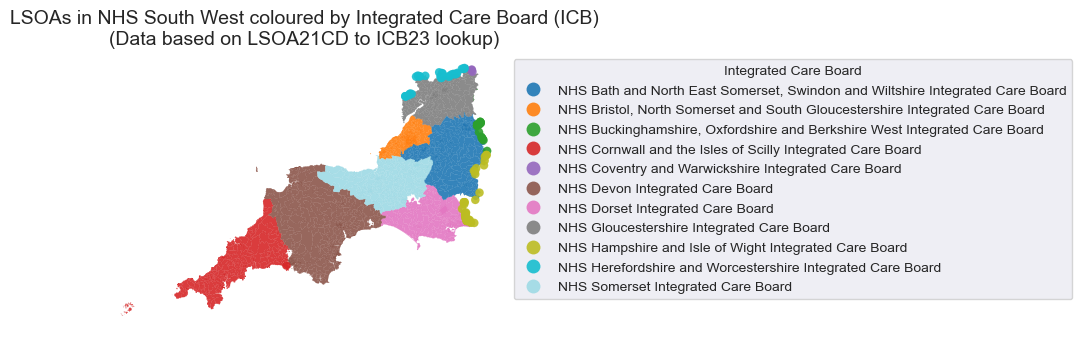

In [13]:
# Visualise ICBs

# Use your actual variable name
gdf = lsoa_sw_gdf

if isinstance(gdf, gpd.GeoDataFrame) and 'ICB23NM' in gdf.columns:
    missing_icb_count = gdf['ICB23NM'].isna().sum()
    if missing_icb_count > 0:
        print(f"Warning: {missing_icb_count} LSOAs have missing ICB information and may not be coloured correctly.")

    num_icbs = gdf['ICB23NM'].nunique(dropna=True)
    cmap = 'tab10' if num_icbs <= 10 else 'tab20'
    print(f"Mapping {num_icbs} unique ICBs using colormap '{cmap}'.")

    fig, ax = plt.subplots(figsize=(10, 12))

    gdf.plot(
        ax=ax,
        column='ICB23NM',
        categorical=True,
        cmap=cmap,
        legend=True,
        legend_kwds={
            'title': "Integrated Care Board",
            'loc': 'upper left',
            'bbox_to_anchor': (1, 1)
        },
        edgecolor='face',
        linewidth=0.1,
        alpha=0.9
    )

    try:
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=gdf.crs)
    except Exception as e:
        print(f"Basemap not added: {e}")

    ax.set_title(
        "LSOAs in NHS South West coloured by Integrated Care Board (ICB)\n(Data based on LSOA21CD to ICB23 lookup)",
        fontsize=14)
    ax.axis("off")
    plt.tight_layout()
    plt.show()

else:
    print("\nSkipping ICB map visualization:")
    if not isinstance(gdf, gpd.GeoDataFrame):
        print("- GeoDataFrame not found or is not a GeoDataFrame.")
    if 'ICB23NM' not in gdf.columns:
        print("- 'ICB23NM' column not found in the GeoDataFrame.")


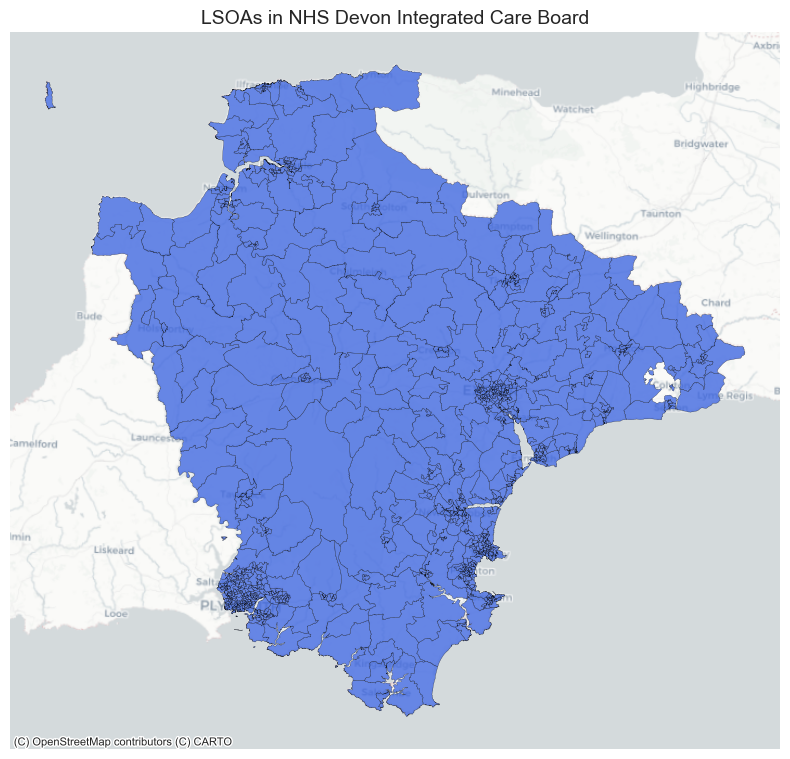

In [15]:
# Single ICB

# Set the name of the ICB you want to plot
single_icb = "NHS Devon Integrated Care Board"

# Filter to only include that ICB (and non-null geometry)
icb_gdf = lsoa_sw_gdf[(lsoa_sw_gdf['ICB23NM'] == single_icb) & lsoa_sw_gdf.geometry.notnull()]

if not icb_gdf.empty:
    fig, ax = plt.subplots(figsize=(8, 10))
    icb_gdf.plot(
        ax=ax,
        color='royalblue',        # Use only 'color' for a single group
        edgecolor='black',
        linewidth=0.2,
        alpha=0.8
    )

    try:
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=icb_gdf.crs)
    except Exception as e:
        print(f"Basemap not added: {e}")

    ax.set_title(f"LSOAs in {single_icb}", fontsize=14)
    ax.axis("off")
    plt.tight_layout()
    plt.show()
else:
    print(f"No LSOAs found for '{single_icb}'")

In [16]:
# With Drop-down

import ipywidgets as widgets
from IPython.display import display, clear_output

# --- Prepare the Dropdown of Unique ICBs ---
unique_icbs = sorted(lsoa_sw_gdf['ICB23NM'].dropna().unique())
dropdown = widgets.Dropdown(
    options=unique_icbs,
    value=unique_icbs[0],
    description='ICB:',
    disabled=False,
)

# --- Plotting Function ---
def plot_icb(selected_icb):
    clear_output(wait=True)  # Clears previous output
    display(dropdown)        # Re-displays the dropdown

    icb_gdf = lsoa_sw_gdf[
        (lsoa_sw_gdf['ICB23NM'] == selected_icb) &
        lsoa_sw_gdf.geometry.notnull()
    ]

    if not icb_gdf.empty:
        fig, ax = plt.subplots(figsize=(8, 10))
        icb_gdf.plot(
            ax=ax,
            color='royalblue',
            edgecolor='black',
            linewidth=0.2,
            alpha=0.8
        )
        try:
            ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=icb_gdf.crs)
        except Exception as e:
            print(f"Basemap not added: {e}")
        ax.set_title(f"LSOAs in {selected_icb}", fontsize=14)
        ax.axis("off")
        plt.tight_layout()
        plt.show()
    else:
        print(f"No LSOAs found for '{selected_icb}'")

# --- Connect Dropdown to Plotting Function ---
widgets.interact(plot_icb, selected_icb=dropdown)


interactive(children=(Dropdown(description='ICB:', options=('NHS Bath and North East Somerset, Swindon and Wil…

<function __main__.plot_icb(selected_icb)>